## Q6: PCA

### Why PCA is Important

Imagine working with a dataset related to **image recognition**, where each image is represented by thousands of pixel values.  
For instance, a facial image with a resolution of 100 × 100 pixels results in 10,000 features (one per pixel).

At first glance, it may seem manageable to analyze such data, but you quickly encounter a serious problem:  
**the dataset becomes too high-dimensional**, making computations slow, storage heavy, and models prone to overfitting.

This is precisely where **Principal Component Analysis (PCA)** becomes essential.  
PCA enables us to **reduce the dimensionality** of the dataset by extracting the most informative combinations of features, thereby preserving the structure of the data with far fewer dimensions.



### How PCA Works

PCA transforms the original features into a new set of uncorrelated features called **principal components**. These components are ordered such that:

- The **first principal component (PC1)** captures the direction of maximum variance.
- The **second principal component (PC2)** captures the next highest variance in a direction orthogonal to PC1.
- And so on.

Mathematically, PCA involves the following steps:

- **Step 1: Center the Data**  
  Subtract the mean from each feature to center the data around the origin:
  
  $$ X_{\text{centered}} = X - \bar{X} $$

- **Step 2: Covariance Matrix**  
  Compute the covariance matrix to quantify how variables vary together:

  $$ C = \frac{1}{n-1} X_{\text{centered}}^T X_{\text{centered}} $$

- **Step 3: Eigen Decomposition**  
  Solve for eigenvalues ($\lambda$) and eigenvectors ($v$) of the covariance matrix:

  $$ Cv = \lambda v $$

  Here, each eigenvector represents a principal component, and each eigenvalue represents the variance explained by that component.

- **Step 4: Rank and Select Components**  
  Sort eigenvectors by their corresponding eigenvalues in descending order.  
  Choose the top $k$ principal components that together explain a significant portion (e.g., 90%) of the total variance.

- **Step 5: Project the Data**  
  Finally, project the original data onto the selected eigenvectors to obtain the reduced-dimension representation.



### Deciding the Number of Components ($k$)

The number of principal components $k$ is chosen based on the cumulative variance explained.  
Typically, we select the smallest $k$ such that:

$$ \text{Cumulative Variance} \geq 85\% \text{ or } 90\% $$

This ensures that the reduced dataset still retains most of the important information.



### Benefits of PCA in Practice

By reducing the feature space from thousands of dimensions to just a few principal components:

- **Computational Efficiency** improves significantly.
- **Storage Requirements** decrease.
- **Model Generalization** enhances, reducing overfitting risks.
- **Visualization** becomes feasible (e.g., 2D or 3D scatter plots of complex data).



### PCA in Unsupervised Learning

One of the most powerful aspects of PCA is its **unsupervised nature**:  
PCA does not require labeled data to uncover structure.

For example, in the context of breast cancer data:

- When applying PCA on gene expression profiles, samples naturally separated into distinct clusters based on **ER status (ER+ or ER–)**.
- Notably, PCA achieved this separation **without being told** which samples were ER+ or ER–, purely based on variance patterns.

Thus, PCA can reveal biologically meaningful groupings and trends **even when class labels are unavailable or unknown** — making it an essential tool in exploratory data analysis and pattern discovery.




### 1) Loading and Preprocessing Data

We begin by importing the required libraries and loading three key data files:

- **Class Labels**: This file contains binary labels indicating estrogen receptor (ER) status for each sample. ER+ is encoded as `1`, and ER− as `0`.

- **Gene Mapping**: We read a compressed file that maps internal gene IDs to gene symbols. Commented lines starting with `#` are ignored.

- **Gene Expression Data**: This file contains expression values for thousands of genes across multiple samples. Column names are cleaned to ensure consistency.

Next, we extract the expression values for two genes of interest:
- **XBP1** (known ID = 4404)
- **GATA3** (ID fetched from gene mapping based on symbol)

Finally, we generate a color map (`red` for ER+ and `black` for ER−) to use in visualizations.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzip
from io import StringIO

# Load class labels (1 = ER+, 0 = ER-)
class_labels = pd.read_csv('data/class.tsv', sep='\t', header=None)
labels = class_labels[0].values

# Load gene mapping data
with gzip.open('data/columns.tsv.gz', 'rt') as f:
    lines = [line for line in f if not line.startswith('#')]
filtered_content = StringIO(''.join(lines))
gene_mapping = pd.read_csv(filtered_content, sep='\t')

# Load gene expression data
with gzip.open('data/filtered.tsv.gz', 'rt') as f:
    expression_data = pd.read_csv(f, sep='\t')
expression_data.columns = expression_data.columns.astype(str).str.strip()

# Retrieve gene IDs for XBP1 and GATA3
xbp1_id = 4404
gata3_id = gene_mapping[gene_mapping['GeneSymbol'] == 'GATA3']['ID'].values[0]

print(gata3_id)
print('4404' in expression_data.columns)

# Extract expression values
xbp1_expression = expression_data[str(xbp1_id)].values
gata3_expression = expression_data[str(gata3_id)].values

# Assign colors for visualization based on class labels
colors = ['black' if label == 0 else 'red' for label in labels]


4359
True


### 2) PCA Implementation

We define a custom function `perform_pca` to apply Principal Component Analysis (PCA) to a given dataset `X`.

The process involves:
1. **Centering the Data**: Each feature's mean is subtracted to normalize the dataset.
2. **Covariance Matrix**: We compute the covariance matrix to understand the variance relationship between features.
3. **Eigen Decomposition**: Eigenvalues and eigenvectors of the covariance matrix are computed using `np.linalg.eigh` (suitable for symmetric matrices).
4. **Sorting**: Eigenvalues and corresponding eigenvectors are sorted in descending order of variance explained.
5. **Dimensionality Reduction (optional)**: If `k` is specified, only the top `k` principal components are returned.

The function returns:
- `eigenvectors`: Principal axes in feature space.
- `eigenvalues`: Variance explained by each principal component.
- `x_centered`: The centered version of the input data matrix.


In [7]:
def perform_pca(X, labels=None, k=None):
    """
    Perform PCA with consistent orientation of principal components for 2D visualization.

    Parameters:
    X : numpy array (n_samples x n_features)
    labels : numpy array, optional (n_samples,)
        Binary class labels for orientation (1 = ER+, 0 = ER-)
    k : int, optional
        Number of principal components to return

    Returns:
    eigenvectors : numpy array
        Oriented eigenvectors
    eigenvalues : numpy array
        Corresponding eigenvalues
    x_centered : numpy array
        Mean-centered input data
    """
    x_centered = X - np.mean(X, axis=0)
    cov_matrix = np.cov(x_centered, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Orient PC1 based on correlation with labels
    if labels is not None:
        pc1 = eigenvectors[:, 0]
        proj_pc1 = np.dot(x_centered, pc1)
        if np.mean(proj_pc1[labels == 1]) < np.mean(proj_pc1[labels == 0]):
            eigenvectors[:, 0] *= -1  # Flip PC1

        # For 2D: Flip PC2 to maintain right-handed coordinate system
        if eigenvectors.shape[1] >= 2:
            pc1 = eigenvectors[:, 0]
            pc2 = eigenvectors[:, 1]
            cross = np.cross(pc1, pc2)
            if cross < 0:
                eigenvectors[:, 1] *= -1  # Flip PC2 to ensure right-handed system

    if k is not None:
        eigenvectors = eigenvectors[:, :k]
        eigenvalues = eigenvalues[:k]

    return eigenvectors, eigenvalues, x_centered


### 3) Figure 1(a): Scatter Plot of GATA3 vs. XBP1 Expression

This scatter plot visualizes the relationship between the expression levels of **GATA3** and **XBP1** genes across different samples.

- Each point represents a single sample.
- The color of each point indicates its ER status:
  - **Red**: ER+ (Estrogen Receptor Positive)
  - **Black**: ER− (Estrogen Receptor Negative)

This plot helps identify whether expression patterns of these genes are associated with ER status.


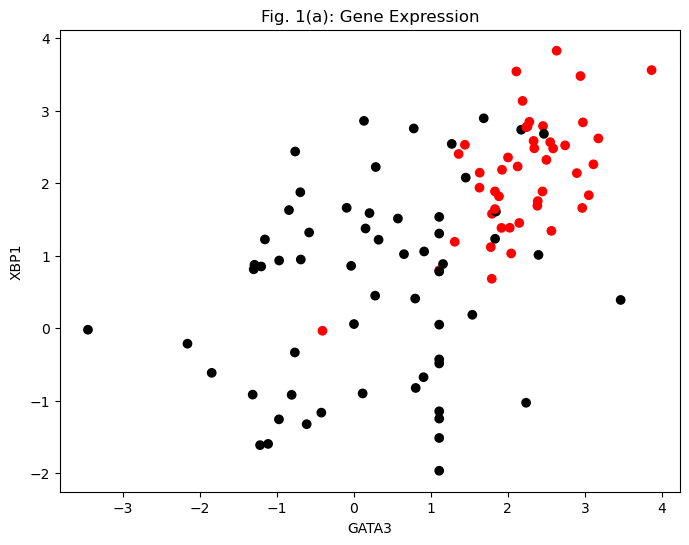

In [8]:
plt.figure(figsize=(8, 6))
plt.scatter(gata3_expression, xbp1_expression, c=colors)
plt.xlabel('GATA3')
plt.ylabel('XBP1')
plt.title('Fig. 1(a): Gene Expression')
plt.savefig('figure_1a.png')
plt.show()


### 4) Figure 1(b): Principal Component Directions on Gene Expression Data

This plot overlays the directions of the first two **principal components (PC1 and PC2)** onto the scatter plot of **GATA3** vs **XBP1** gene expression.

- **PC1 and PC2** represent the directions of maximum variance in the data.
- The vectors are drawn as arrows from the **mean point** of the dataset.
- The projections of the data on these components help in visualizing the **spread and orientation** of the dataset in a reduced space.

This visualization highlights the variance structure and can guide further dimensionality reduction or clustering.


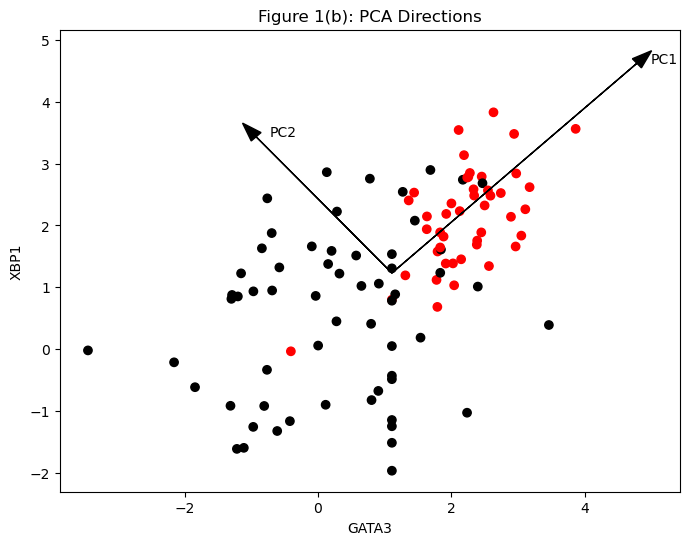

In [9]:
x = np.column_stack((gata3_expression, xbp1_expression))
eigenvectors, eigenvalues, x_centered = perform_pca(x, labels=labels)

pc1 = eigenvectors[:, 0]
pc2 = eigenvectors[:, 1]
projection_pc1 = np.dot(x_centered, pc1)
projection_pc2 = np.dot(x_centered, pc2)

plt.figure(figsize=(8, 6))
plt.scatter(gata3_expression, xbp1_expression, c=colors)

mean_gata3 = np.mean(gata3_expression)
mean_xbp1 = np.mean(xbp1_expression)

plt.arrow(mean_gata3, mean_xbp1, pc1[0]*5, pc1[1]*5,
          head_width=0.2, head_length=0.3, fc='black', ec='black')
plt.arrow(mean_gata3, mean_xbp1, pc2[0]*3, pc2[1]*3,
          head_width=0.2, head_length=0.3, fc='black', ec='black')

plt.text(mean_gata3 + pc1[0]*5 + 0.2, mean_xbp1 + pc1[1]*5, 'PC1')
plt.text(mean_gata3 + pc2[0]*3 + 0.2, mean_xbp1 + pc2[1]*3, 'PC2')

plt.xlabel('GATA3')
plt.ylabel('XBP1')
plt.title('Figure 1(b): PCA Directions')
plt.savefig('figure_1b.png')
plt.show()


### 5) Figure 1(c): Projection of Samples onto PC1

This figure shows how the samples are distributed along the **first principal component (PC1)**.

- **Top subplot (All)**: Displays all samples projected onto PC1, color-coded by ER status.
- **Middle subplot (ER−)**: Shows only the ER− samples.
- **Bottom subplot (ER+)**: Shows only the ER+ samples.

This projection helps in identifying whether PC1 effectively separates the ER+ and ER− classes.

The proportion of variance explained by each component:
- **PC1**: Indicates how much of the total variance is captured along the first principal direction.
- **PC2**: Indicates the contribution of the second direction.

These values help assess how informative each principal component is for the data.



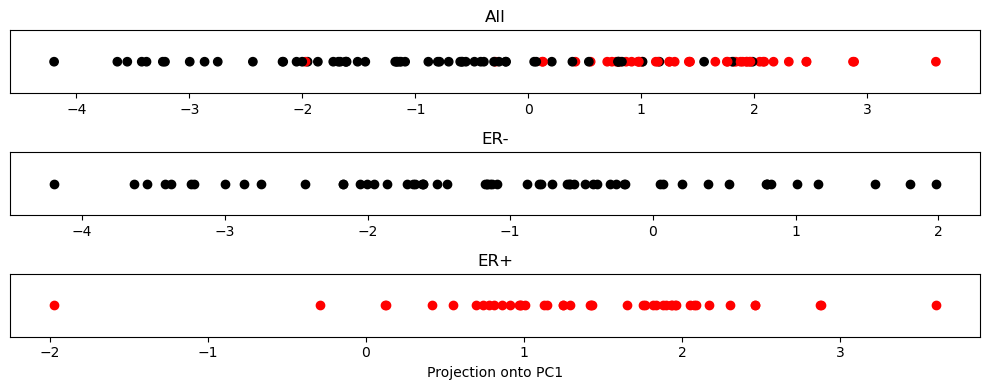

Variance explained by PC1: 0.7792
Variance explained by PC2: 0.2208


In [10]:
# Separate projections based on class labels
er_pos_pc1 = projection_pc1[labels == 1]
er_neg_pc1 = projection_pc1[labels == 0]

plt.figure(figsize=(10, 4))

# All samples
plt.subplot(3, 1, 1)
plt.scatter(projection_pc1, np.zeros_like(projection_pc1), c=colors)
plt.yticks([])
plt.title('All')

# ER- samples
plt.subplot(3, 1, 2)
plt.scatter(er_neg_pc1, np.zeros_like(er_neg_pc1), c='black')
plt.yticks([])
plt.title('ER-')

# ER+ samples
plt.subplot(3, 1, 3)
plt.scatter(er_pos_pc1, np.zeros_like(er_pos_pc1), c='red')
plt.yticks([])
plt.title('ER+')
plt.xlabel('Projection onto PC1')

plt.tight_layout()
plt.savefig('figure_1c.png')
plt.show()

# Variance explained by PC1 and PC2
print(f"Variance explained by PC1: {eigenvalues[0]/sum(eigenvalues):.4f}")
print(f"Variance explained by PC2: {eigenvalues[1]/sum(eigenvalues):.4f}")
